In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import spotipy

from matplotlib import pyplot as plt

In [4]:
#read in data
data = pd.read_csv('../dat/data.csv')
data_no_duplicates = pd.read_csv('../dat/data_no_duplicates.csv')

In [5]:
# scaling data
def pre_process_data(data):
    data.drop_duplicates(subset=['track_id'], keep=False, inplace=True)
    metadata = ['artist', 'album', 'track_name', 'track_id', 'country', 'continent', 'popularity'] # features that are actually not required 
    feature_data = np.asarray(data.drop(metadata, axis = 1))
    scaled_data = StandardScaler().fit_transform(feature_data)
    return scaled_data

In [6]:
scaled_data = pre_process_data(data)
scaled_data_no_duplicates = pre_process_data(data_no_duplicates)

### Regression with chart data

In [9]:
def get_root_mean_squared_error(predictions, labels):
    rsme = 0
    for pred, label in zip(predictions, labels):
        rsme += (label - pred)**2
    return np.sqrt(1/len(predictions) * rsme)

In [10]:
X = scaled_data
y = data['popularity'].values

In [11]:
########################################## normal regression #######################################################

def print_model_performance(reg, X_train, X_test, y_train, y_test):
    predictions = reg.predict(X_train)
    print(f'prediction: {list(predictions[:5])}')
    print(f'y: {y_train[:5]}')
    rsme_normal = np.sqrt(mean_squared_error(y_train, predictions))
    print(f'train error: {rsme_normal}')

    # cross validation
    model = LinearRegression()
    scorer = make_scorer(get_root_mean_squared_error)
    cv = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
    print(f'mean cross validation error: {scores.mean()}')

    # get test error
    predictions_training = reg.predict(X_test)
    print(f'test error: {np.sqrt(mean_squared_error(y_test, predictions_training))}')

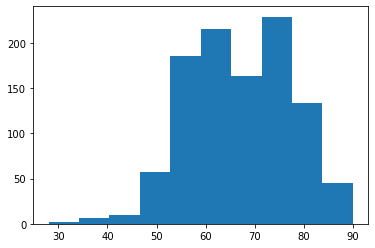

In [12]:
# look at popularity distribution
plt.hist(data['popularity']);

In [13]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size = 0.33, random_state = 42)

In [14]:
# plot residuals
def plot_residuals(X_train, y_train, reg):
    prediction = reg.predict(X_train)
    res = y_train - prediction
    fig = plt.figure(figsize=(13,7))
    plt.subplot(221)
    plt.title('residuals against prediction')
    plt.plot(prediction, res, 'b.');
    plt.subplot(222)
    plt.hist(res, bins=50)
    plt.title('residual frequency')
    plt.subplot(223)
    plt.title('predictions')
    plt.hist(prediction, bins=50)
    plt.subplot(224)
    plt.title('y')
    plt.hist(y_train, bins=50)


**normal data set**

In [15]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)

prediction: [69.37452596189219, 68.47508857143644, 68.17461479302474, 65.44855121839184, 72.49635224935558]
y: [54. 76. 74. 47. 73.]
train error: 9.903608373114572
mean cross validation error: 10.246283005405177
test error: 10.366843965523662


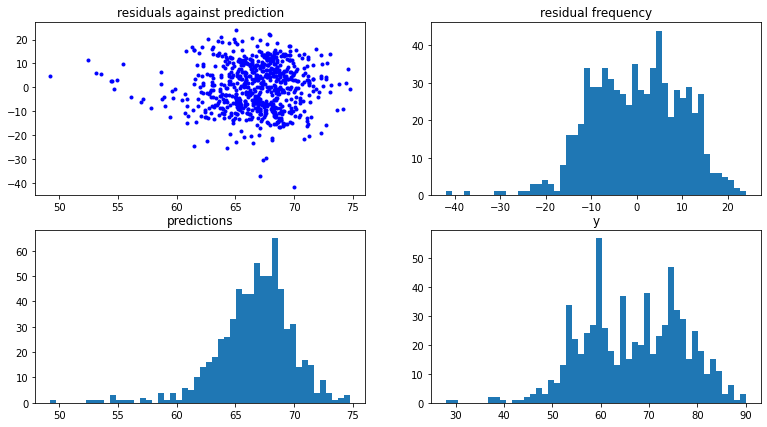

In [16]:
plot_residuals(X_train, y_train, reg)

**data with no duplictes**

In [18]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_data_no_duplicates, y, test_size = 0.33, random_state = 42)

In [19]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)

prediction: [69.37452596189219, 68.47508857143644, 68.17461479302474, 65.44855121839184, 72.49635224935558]
y: [54. 76. 74. 47. 73.]
train error: 9.903608373114572
mean cross validation error: 10.143232755614855
test error: 10.366843965523662


With linear regression, even the trainings error is high.

### Evaluate predictions with residual plot

does not look proissing, lots of outliers

#### Support vector regression

In [20]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
print_model_performance(regressor, X_train, X_test, y_train, y_test)

prediction: [67.67756127741637, 68.33269819487994, 67.32296312173307, 68.00066936463783, 72.89966373041314]
y: [54. 76. 74. 47. 73.]
train error: 9.751146239478512
mean cross validation error: 10.101521388700245
test error: 10.195296913784427


In [21]:
regressor = SVR()
scorer = make_scorer(get_root_mean_squared_error)

In [22]:
p_grid = {'kernel': ['linear', 'rbf', 'ploy']}
outer_cv = KFold(n_splits=5, shuffle=True)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=regressor, param_grid=p_grid, cv=outer_cv, scoring=scorer, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................................kernel=linear; total time=   0.0s
[CV 2/5] END ..................................kernel=linear; total time=   0.0s
[CV 3/5] END ..................................kernel=linear; total time=   0.0s
[CV 4/5] END ..................................kernel=linear; total time=   0.0s
[CV 5/5] END ..................................kernel=linear; total time=   0.0s
[CV 1/5] END .....................................kernel=rbf; total time=   0.0s
[CV 2/5] END .....................................kernel=rbf; total time=   0.0s
[CV 3/5] END .....................................kernel=rbf; total time=   0.0s
[CV 4/5] END .....................................kernel=rbf; total time=   0.0s
[CV 5/5] END .....................................kernel=rbf; total time=   0.0s
[CV 1/5] END ....................................kernel=ploy; total time=   0.0s
[CV 2/5] END ....................................

/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/svm/_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/florian/miniconda3/envs/statistics/lib/python3.8/site-packages/sklearn/svm/_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn/svm/_libsvm.pyx", line 176, in sklearn.svm._libsvm.fit
ValueError: 'ploy' is not in list

  warnings.warn("Estimator fit failed. The score on this train-

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVR(), param_grid={'kernel': ['linear', 'rbf', 'ploy']},
             scoring=make_scorer(get_root_mean_squared_error), verbose=5)

In [23]:
clf.best_score_

10.434834821751181

### load keggel data 

keggel data set is used to get more training data

In [25]:
keggel_spotify = pd.read_csv('../dat/tracks_features.csv', header=0)

In [26]:
keggel_spotify[keggel_spotify['year'] > 2005]

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
22,2SwgVZn9S4NGueAaEAryf1,Man on a Mission,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],1,1,False,0.787,...,0.0315,0.29200,0.000025,0.1010,0.962,119.946,224307,4.0,2018,2018-04-10
23,0QCQ1Isa0YPVyIbs6JwpO1,Do It for Love,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],2,1,False,0.587,...,0.0586,0.10700,0.000000,0.0574,0.832,87.976,238000,4.0,2018,2018-04-10
24,3kIBEFhsZOeeKGebxRraOb,Someday We'll Know,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],3,1,False,0.565,...,0.0308,0.02330,0.000010,0.0819,0.461,109.977,268013,4.0,2018,2018-04-10
25,5dNDRw6qjDcnbW3luRhElU,Forever for You,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],4,1,False,0.651,...,0.0240,0.56200,0.000006,0.1860,0.370,97.030,277813,4.0,2018,2018-04-10
26,561UU4MvlsCenN1x7leYCh,Life's Too Short,Do It for Love,4evw6IBex3N8x1oA2axMTH,['Daryl Hall & John Oates'],['77tT1kLj6mCWtFNqiOmP9H'],5,1,False,0.833,...,0.0347,0.07600,0.013600,0.0731,0.974,116.013,209960,4.0,2018,2018-04-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],2,1,False,0.264,...,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,2014,2014-01-09
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],3,1,False,0.796,...,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,2014,2014-01-09
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],4,1,False,0.785,...,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,2014,2014-01-09
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],5,1,False,0.665,...,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,2014,2014-01-09


In [27]:
cid = '020f2ed496864af6ab98a08846eac5da'
secret = 'abd17ef2d04d4d3abd706ec03db71646'

client_credentials_manager = spotipy.SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [28]:
from tqdm import tqdm
import random

In [29]:
def get_popularity(keggel_spotify):
    popularity = []
    for idx in tqdm(keggel_spotify.id):
        popularity.append((sp.track(idx)['popularity']))
    keggel_spotify['popularity'] = popularity
    return keggel_spotify

In [30]:
random.seed(69)
idx = np.arange(0,len(keggel_spotify))
sample_idx = random.sample(list(idx), 1000)

In [31]:
sample_keggel = keggel_spotify.iloc[sample_idx]
sample_keggel = get_popularity(sample_keggel)

100%|███████████████████████████████████████| 1000/1000 [01:35<00:00, 10.48it/s]
/tmp/ipykernel_25067/1063456381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keggel_spotify['popularity'] = popularity


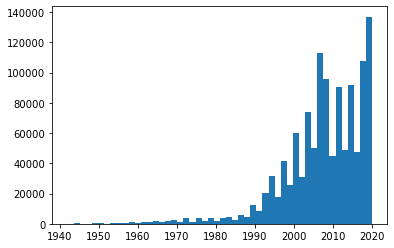

In [32]:
plt.hist(keggel_spotify['year'][keggel_spotify['year']>1940], bins=50);

(array([748., 106.,  59.,  41.,  26.,  10.,   6.,   1.,   2.,   1.]),
 array([ 0. ,  8.3, 16.6, 24.9, 33.2, 41.5, 49.8, 58.1, 66.4, 74.7, 83. ]),
 <BarContainer object of 10 artists>)

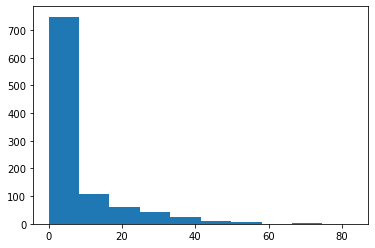

In [33]:
plt.hist(sample_keggel['popularity'])

In [34]:
sample_keggel.head()
sample_keggel.to_csv('keggel_sample.csv', index=None)

## Build training data with charts and keggel songs

Older songs seem to have no popularity measure, so exclude them

In [35]:
data_no_duplicates.drop_duplicates(subset=['track_id'], keep=False, inplace=True)
metadata = ['artist', 'album', 'track_name', 'track_id', 'country', 'continent'] # features that are actually not required 
data_no_duplicates = data_no_duplicates.drop(metadata, axis = 1)

In [36]:
# get shared features
sample_keggel_cols = set(sample_keggel.columns)
data_no_duplicates_cols = set(data_no_duplicates.columns)
intersection =  list(data_no_duplicates_cols.intersection(sample_keggel_cols))
print(intersection)

['instrumentalness', 'energy', 'mode', 'loudness', 'tempo', 'danceability', 'duration_ms', 'key', 'speechiness', 'time_signature', 'popularity', 'valence', 'liveness']


In [37]:
# separate features and labels
training_keggel = sample_keggel[intersection]
training_data = data_no_duplicates[intersection]
regression_data = training_data.append(training_keggel)
y = regression_data['popularity'].reset_index(drop=True)
regression_data = regression_data.drop('popularity', axis=1).reset_index(drop=True)

In [38]:
# exclude categotial varibles from scaling
cat_features = ['key', 'mode', 'time_signature']
categorial_columns = regression_data[cat_features].astype(str).reset_index(drop=True)
regression_data = regression_data.drop(cat_features, axis=1)

In [39]:
# scale data
scaled_regression_data = StandardScaler().fit_transform(regression_data)
scaled_regression_data = pd.DataFrame(scaled_regression_data)
scaled_regression_data.columns = regression_data.columns
# merge with categorial data
scaled_regression_data[cat_features] = categorial_columns

In [41]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_regression_data, y, test_size = 0.33, random_state = 42)

prediction: [11.01668421445795, 15.152115021241265, 13.631283898377898, 43.410639436986386, 27.938992911250132]
y: 1639     5.0
1310     1.0
1320    15.0
1023    61.0
1235     0.0
Name: popularity, dtype: float64
train error: 24.619353180144376
mean cross validation error: 24.952119389613046
test error: 27.22463401342618


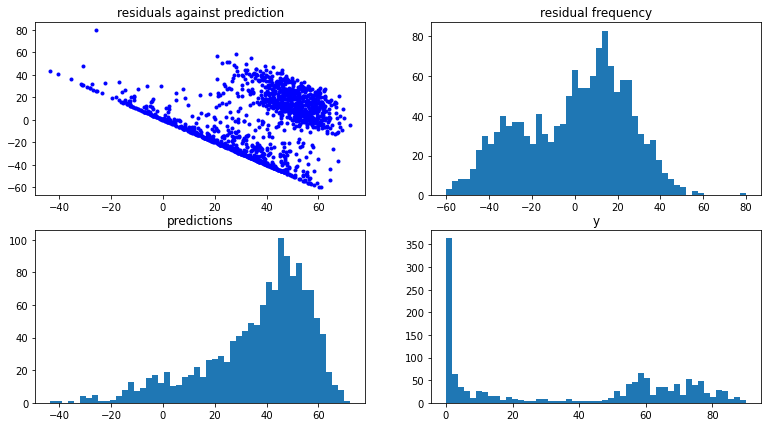

In [42]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, reg)

prediction: [21.84952580153747, 25.878840285907746, 14.213263541515502, 39.47452429329578, 35.137697245735275]
y: 1639     5.0
1310     1.0
1320    15.0
1023    61.0
1235     0.0
Name: popularity, dtype: float64
train error: 25.601880376480185
mean cross validation error: 24.85223559665668
test error: 27.45728318368986


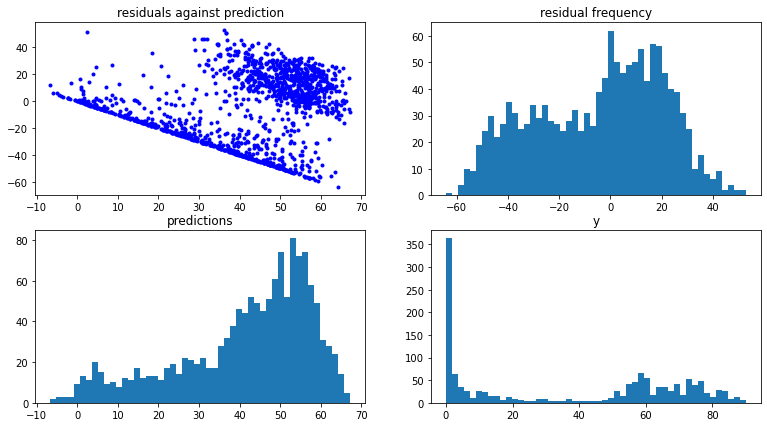

In [43]:
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)
print_model_performance(regressor, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, regressor)

In [44]:
training_keggel.shape
train_keggel = scaled_regression_data.iloc[-1000:]
label_keggel = y.iloc[-1000:]

In [45]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(train_keggel, label_keggel, test_size = 0.2, random_state = 42)

prediction: [-0.0008145961540418911, 0.3041059482380464, 0.3970393811230152, 0.5423726349619555, 0.5411205262626646]
y: [0. 0. 0. 1. 0.]
train error: 0.41109092121443735
mean cross validation error: 0.4127210363480664
test error: 0.43761466817248823
[0. 0. 0. ... 1. 0. 0.]


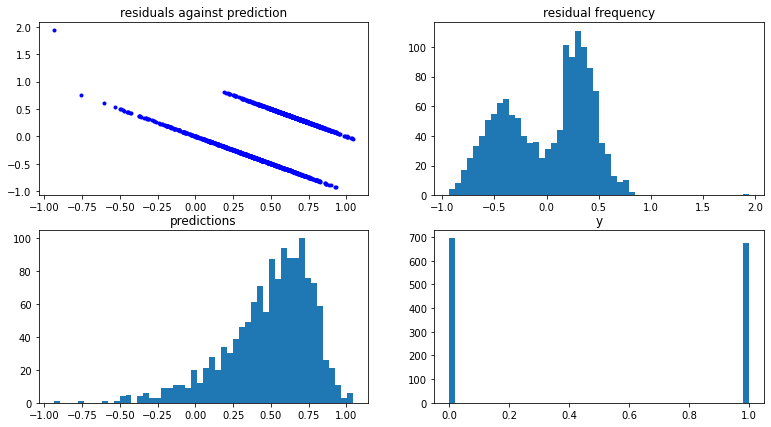

In [87]:
# perform linear regerssion and evaluate
reg = LinearRegression().fit(X_train, y_train)
print_model_performance(reg, X_train, X_test, y_train, y_test)
plot_residuals(X_train, y_train, reg)
print(y_train)

## logistics regression

In [55]:
y_logistic = np.zeros(len(y))
y_logistic[y > 50] = 1
print(y.iloc[-10:], y_logistic[-10:])

2037     0.0
2038     0.0
2039     1.0
2040    12.0
2041     0.0
2042     2.0
2043    15.0
2044    38.0
2045    15.0
2046     1.0
Name: popularity, dtype: float64 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_regression_data, y_logistic, test_size = 0.33, random_state = 42)

In [65]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
predictions = clf.predict(X_train)
print(f'prediction: {list(predictions[:5])}')
print(f'y: {y_train[:5]}')
rsme_normal = np.sqrt(mean_squared_error(y_train, predictions))
print(f'train error: {rsme_normal}')

# cross validation
model = LogisticRegression()
scorer = make_scorer(get_root_mean_squared_error)
cv = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
print(f'mean cross validation error: {scores.mean()}')

# get test error
predictions_training = reg.predict(X_test)
print(f'test error: {np.sqrt(mean_squared_error(y_test, predictions_training))}')

prediction: [0.0, 0.0, 0.0, 1.0, 0.0]
y: [0. 0. 0. 1. 0.]
train error: 0.4278762031504736
mean cross validation error: 0.4400476117072942
test error: 6.985060009189249


In [66]:
clf.score(X_test, y_test)

0.7840236686390533

In [69]:
clf.coef_

array([[-1.29596688, -0.758785  ,  1.74999342,  0.29413042,  1.15916283,
        -0.34826422, -0.08684534, -0.4087223 , -0.14655519, -0.0303655 ,
        -0.58139202,  0.53921636]])

### log regression using only 3 params wich differ most

In [83]:
scaled_regression_data_three_params = scaled_regression_data[['danceability', 'energy', 'valence', 'loudness']]
scaled_regression_data.shape

(2047, 12)

In [81]:
# split data into test and trainings set
X_train, X_test, y_train, y_test = train_test_split(scaled_regression_data_three_params, y_logistic, test_size = 0.33, random_state = 42)

In [84]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train, y_train)
predictions = clf.predict(X_train)
print(f'trainings score: {clf.score(X_train, y_train)}')
print(f'trainings score: {clf.score(X_test, y_test)}')
clf.coef_

trainings score: 0.775346462436178
trainings score: 0.735207100591716


array([[ 1.24081194, -0.94229323, -0.28018782,  2.24313554]])